<h1><center><strong>Predicting Surface Roughness</strong></center></h1>

## Project Overview

The primary goal is to develop a predictive model that can identify optimal machining parameters to achieve desired Surface Roughness, reducing manufacturing scrap and optimazing production.


## Problem Statement & Motivation

Achieving desired roughness often requires a lot of experimentation which are time-consuming and costly.

The motivation behind this project is to leverage data-driven approaches to `Reduce Iterations`,`Improve Efficiency`, `Quality Control` , `Cost Savings`  by reducing/eliminating the need for test runs to find optimal parameters,  proactively identify parameters that lead to desired surface finishes thereby lowering scrap and reducing machining time.


## Dataset information

Made in the [COMPETENCE CENTER IN MANUFACTURING (CCM)](https://www.ccm.ita.br/), a laboratory of the [AERONAUTICS INSTITUTE OF TECHNOLOGY (ITA)](http://www.ita.br/). Obtained from  

Each row represents a machining run, with columns including:


    depth of cut (ap)
    cutting speed (vc)
    feed rate (f)
    arithmetic mean deviation (Ra)
    skewness (Rsk)
    kurtosis (Rku)
    mean width of profile elements (RSm)
    total height (Rt)
    cutting force (Fc)
    passive force (Fy)
    feed force (Fz)
    resultant force (F)
    tool condition (flank wear width) (TCond)


The dataset size is 612 records, containing 13 features. Data source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)




## Material and equipment

    Material: AISI H13 (mean hardness = 200 HV).
    Machine tool (CNC turning center): ROMI E280 (max rotation = 4k rpm, nominal power = 18.5 kW).
    Cutting tool: SandvikCoromant ISO TNMG 16 04 04-PF 4425; tool shank (holder): ISO MTJNL 2020K 16M1.
    Cutting fluid: a mixture of Blaser Swisslube Vasco 7000 with water in 8%. The acidity (pH) of the mixture was around 8.
    Roughness assessment: Mitutoyo portable roughness tester model Surftest SJ-210.
    Tool wear assessment: digital microscope Dino-Lite model AM4113ZT.
    Forces measurement: dynamometer Kistler Type 9265B, connected to a charge amplifier Kistler Type 5070 and an acquisition software Kistler Dynoware Type 2825A; one computer, and peripherical item: a highly insulated cable, Peripherical Component Interconnect (PCI interface), connection cable, and acquisition plate (A/D).


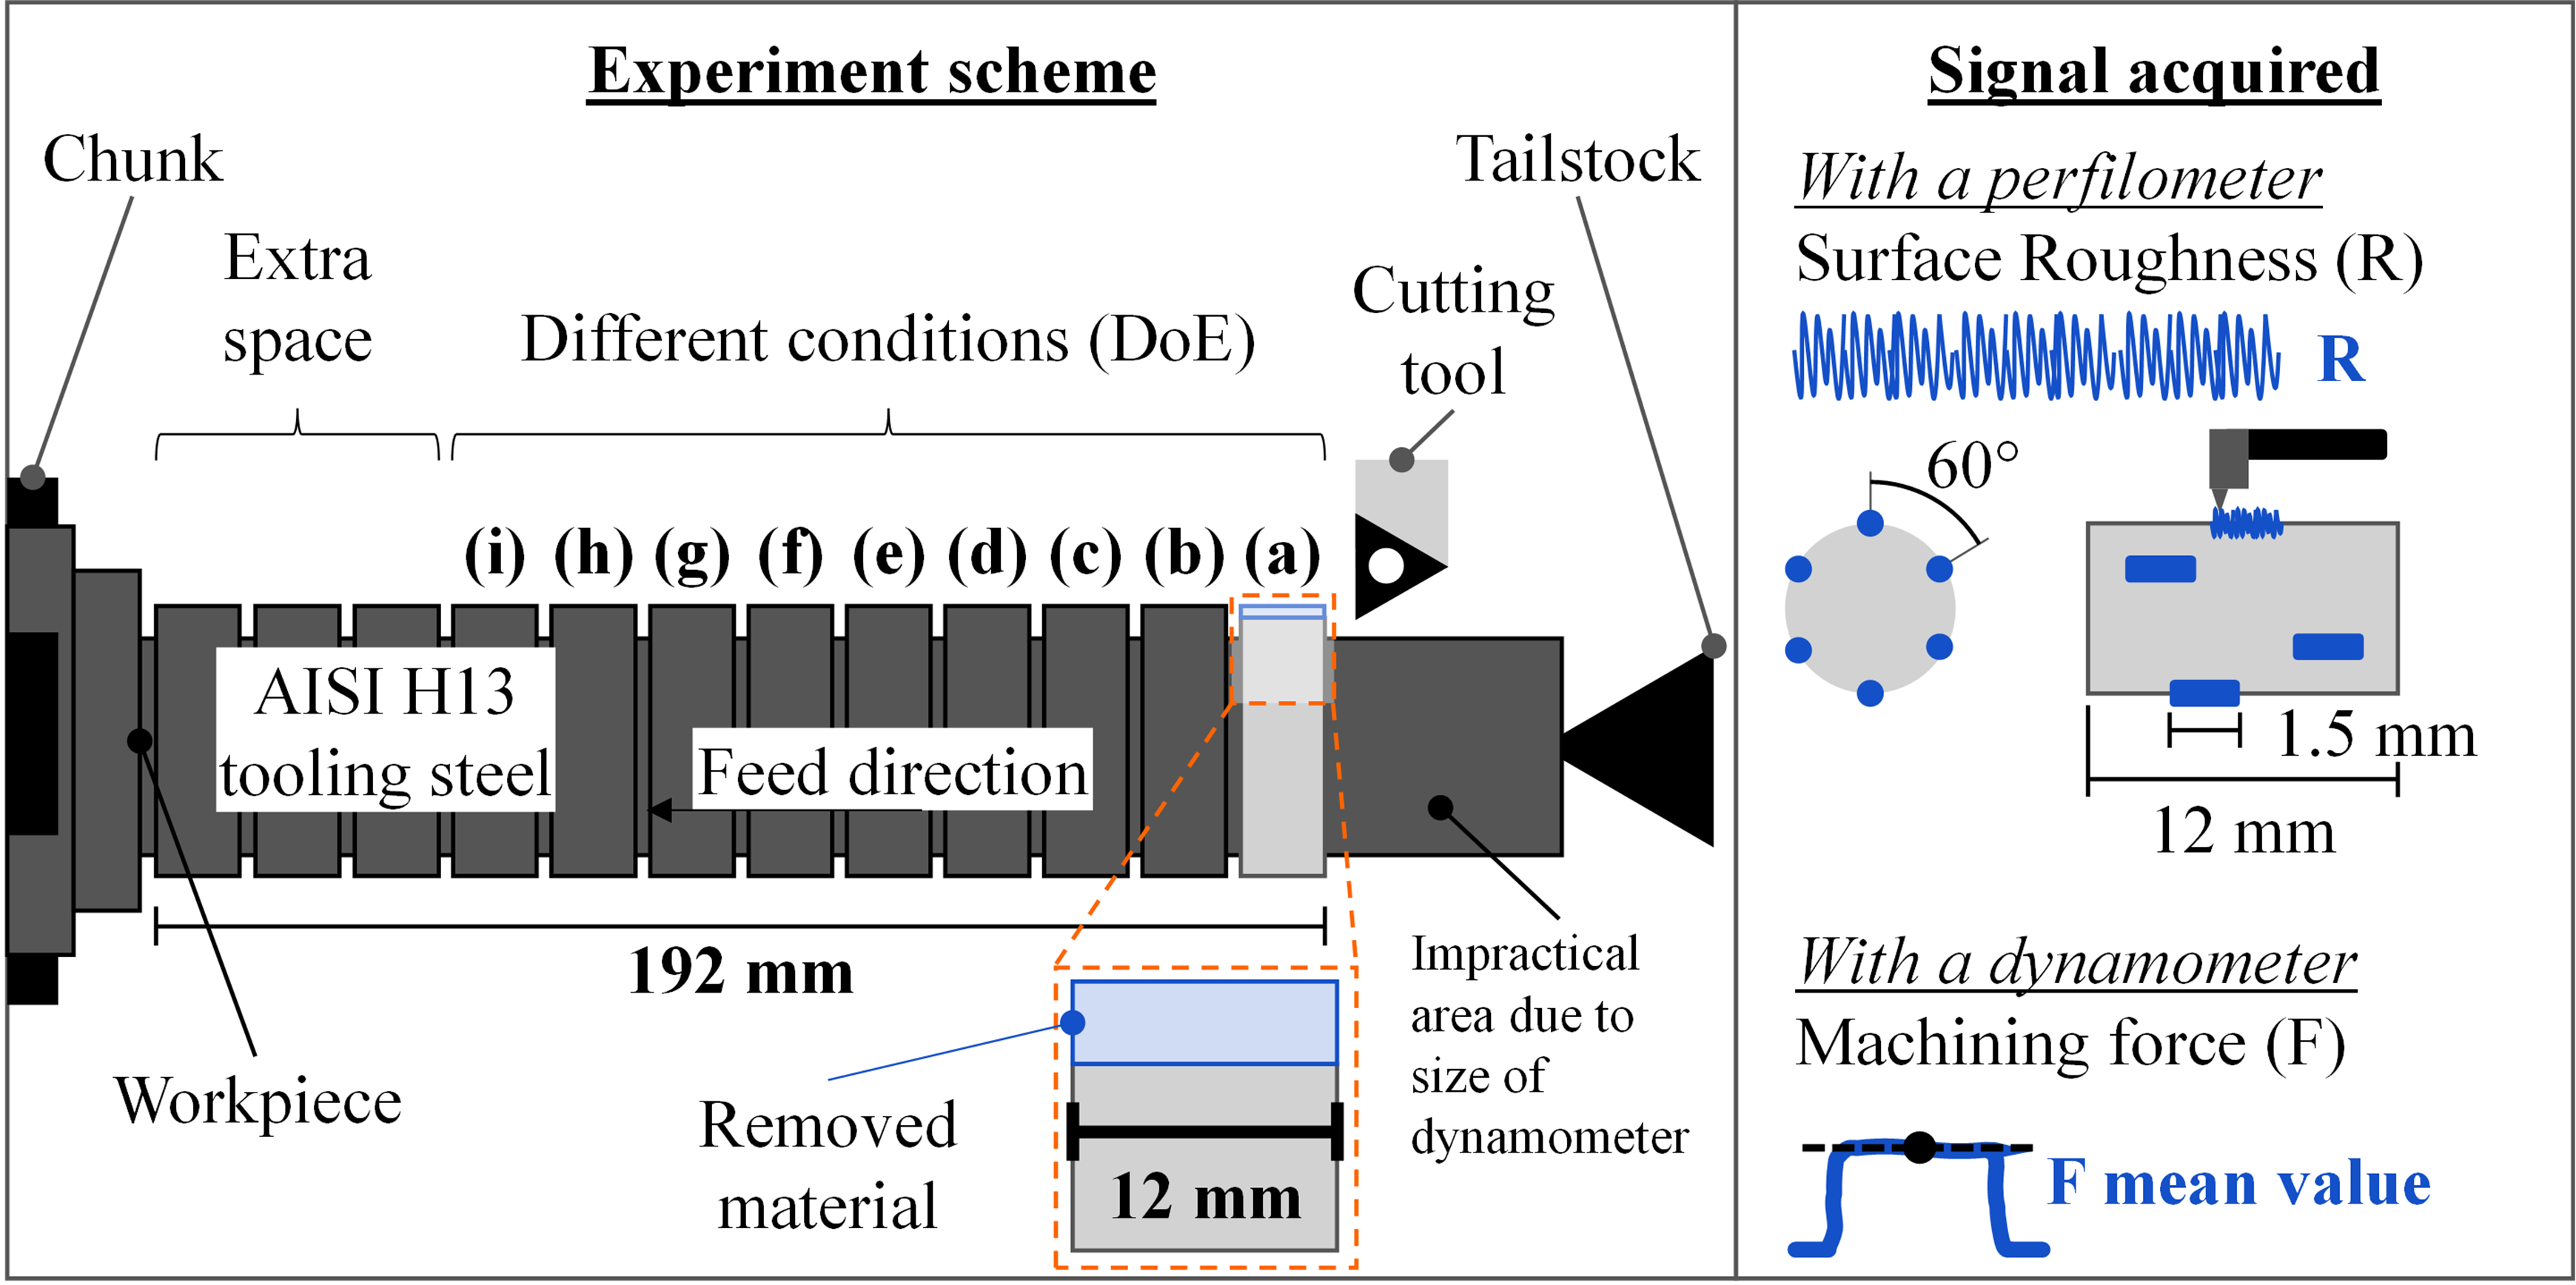

In [2]:
from IPython.display import Image
base_dir = r"E:\Data\CNC\Surface_Roughness"
Image(filename=f"{base_dir}\images\VWjzBJl.png")


<h2><strong>Predicting Surface Roughness (Ra): Data Loading & Exploratory Data Analysis</strong></h2>

This section focuses on loading the raw CNC machining dataset, performing initial data quality checks, and conducting exploratory data analysis to understand the relationships between machining parameters and surface roughness.


## Notebook Objective

This specific notebook focuses on:
1.  **Data Acquisition:** Load dataset.
2.  **Initial Data Inspection:** Perform checks for data quality, missing values, and duplicates.
3.  **Exploratory Data Analysis (EDA):** Examine data through visualizations and statistical summaries to understand:
    * The distribution of the target variable (`Ra`).
    * The distributions of input machining parameters.
    * The relationships between input parameters and `Ra`.
    * Overall data patterns and potential insights for feature engineering and modeling.

### Setup & Imports 

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from IPython.display import Image, HTML, display
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error
import numpy as np
import warnings
from scipy.optimize import minimize

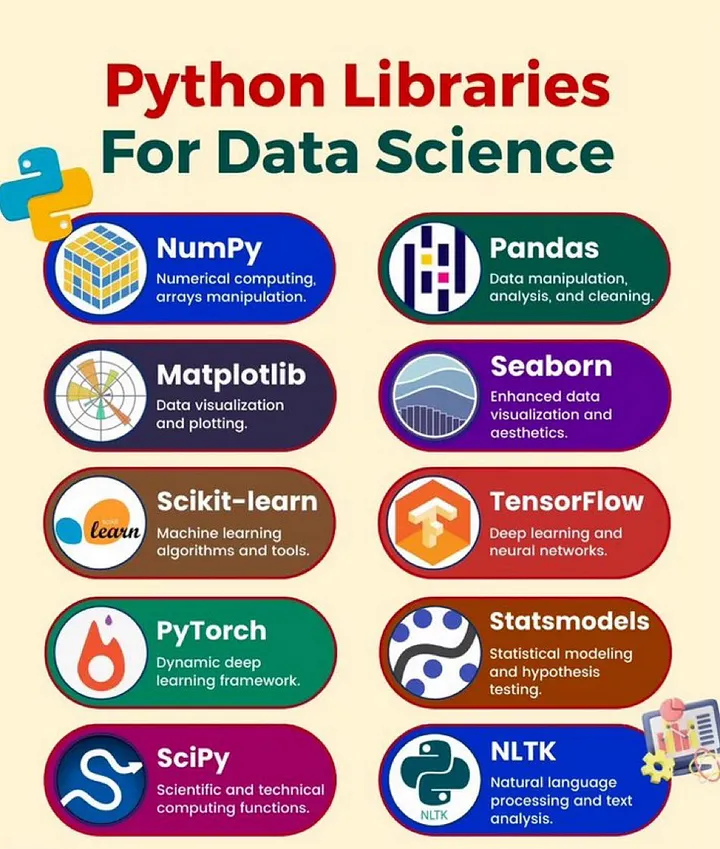

In [8]:
Image(filename=rf"{base_dir}\images\libraries.j")

### Data Loading

source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)

In [3]:
base_dir = r"E:\Data\CNC\Surface_Roughness"

file_paths = [f"{base_dir}/data/raw/Exp1.csv",
              f"{base_dir}/data/raw/Exp2.csv"]

# Load Data
df_list = []
for path in file_paths:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            print(f"Data loaded successfully from: {path}")
            print(f"dataset shape: {df.shape}")
            df_list.append(df)
        except Exception as e:
            print(f"Found '{path}' but failed to load")
            continue

# File was not Found
if df is None:
    print("Error: data files were found.")
    print("Place dataset in the appropriate directory.")

# Merge into a single DataFrame
if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    print(f"\nMerged DataFrame shape: {merged_df.shape}")
else:
    print("No data loaded. Please check file formats or paths.")

Data loaded successfully from: E:\Data\CNC\Surface_Roughness/data/raw/Exp1.csv
dataset shape: (324, 27)
Data loaded successfully from: E:\Data\CNC\Surface_Roughness/data/raw/Exp2.csv
dataset shape: (288, 27)

Merged DataFrame shape: (612, 27)


In [4]:
merged_df.head()

,Run_ID,Experiment,Replica,Tool_ID,Group,Subgroup,Position,Condition,TCond,Machined_length,...,Ra,Rz,Rsk,Rku,RSm,Rt,Fx,Fy,Fz,F
0,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.391,1.855,0.560,2.423,71.4,2.082,49.23,44.46,21.07,69.600499
1,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.359,1.670,0.530,2.229,70.9,1.918,49.23,44.46,21.07,69.600499
2,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.421,1.912,0.634,2.332,71.2,2.062,49.23,44.46,21.07,69.600499
3,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.450,1.961,0.676,2.325,72.8,2.063,49.23,44.46,21.07,69.600499
4,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.360,1.782,0.714,2.636,69.4,1.957,49.23,44.46,21.07,69.600499


### Initial Data Inspection & Quality Checks

In [5]:
print("\033[1m"+"\n--- First 5 rows of the dataset ---"+"\033[0m")
print(merged_df.head())
print("\n"*3)

print("\033[1m"+"\n--- Dataset Info  ---"+"\033[0m")
merged_df.info()
print("\n"*3)

print("\033[1m"+"\n--- Statistical Summary of Numerical Columns ---"+"\033[0m")
print(merged_df.describe().T) 
print("\n")


print("\033[1m"+"\n--- Missing Values  ---"+"\033[0m")
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
    print("\n")
    
print("\033[1m"+"\n--- Duplicate Rows Check ---"+"\033[0m")
num_duplicates = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print(f"Dropping {num_duplicates} duplicate rows...")
    print("\n")
    df.drop_duplicates(inplace=True)
    print(f"New dataset shape after dropping duplicates: {df.shape}")
    print("\n")
else:
    print("No duplicate rows found.")
    print("\n")




--- First 5 rows of the dataset ---
         Run_ID  Experiment  Replica  Tool_ID  Group Subgroup Position  \
0  1_021_B1_4_a           1        1       21      1        2        a   
1  1_021_B1_4_a           1        1       21      1        2        a   
2  1_021_B1_4_a           1        1       21      1        2        a   
3  1_021_B1_4_a           1        1       21      1        2        a   
4  1_021_B1_4_a           1        1       21      1        2        a   

   Condition  TCond  Machined_length  ...     Ra     Rz    Rsk    Rku   RSm  \
0          4    0.0               12  ...  0.391  1.855  0.560  2.423  71.4   
1          4    0.0               12  ...  0.359  1.670  0.530  2.229  70.9   
2          4    0.0               12  ...  0.421  1.912  0.634  2.332  71.2   
3          4    0.0               12  ...  0.450  1.961  0.676  2.325  72.8   
4          4    0.0               12  ...  0.360  1.782  0.714  2.636  69.4   

      Rt     Fx     Fy     Fz          F  


#### Key Observations from the Data

* **Machining Length is Fixed**: Every experiment ran for the exact same length of 12 units. This is great because it means we don't have to worry about length influencing our results; it's a controlled factor.
* **Diverse Tools and Conditions**: The data includes a wide variety of Tool IDs, Groups, and experimental Conditions. This tells us the study explored many different setups and tool types, which is good for understanding their impact.
* **Surface Roughness Varies a Lot**: Measurements like Ra, Rz, and Rt show a lot of spread, indicating that the machining settings have a big effect on these variables.
* **Forces Aren't Constant**: The forces measured during machining (Fx, Fy, Fz, and the total force F), like Surface Roughness, also vary. As expected, since difference in cutting parameters will lead to different forces.
* **Cutting Speed and Feed Rate are Stable**: The cutting speed (vc) and feed rate (f) seem to be held within relatively narrow ranges. This implies that limited values were chosen for these settings across the experiments.
<br><br><br><br><br>

In [6]:
# Drop the specified columns
# To align with our project's goal of predicting `Surface_Roughness_Ra` solely from controllable machining parameters
columns_to_drop = [
    'Run_ID', 'Experiment', 'Replica', 'Tool_ID', 'Group', 'Subgroup', 'Position', 'Cond', 
    'Machined_length', 'Init_diameter', 'Final_diameter', 'CTime', 'R_measurement',
    'Rz', 'Rsk', 'Rku', 'RSm', 'Rt', 'Condition', 'Fx','Fy','Fz'
    
]

# Drop the specified columns
# Use errors='ignore' in case some columns were not present (e.g., if you run this multiple times)
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [7]:
# Rename columns  
rename_mapping = {
    'ap': 'Depth_of_Cut_ap',       
    'vc': 'Cutting_Speed_vc',
    'f': 'Feed_Rate_f',
    'Ra': 'Surface_Roughness_Ra',    
    'TCond': 'Tool_Wear',
    'F': 'Resultant Force'

}

# Apply renaming only to columns that exist in the DataFrame
merged_df.rename(columns={k: v for k, v in rename_mapping.items() if k in merged_df.columns}, inplace=True)


merged_df.head()

,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Surface_Roughness_Ra,Resultant Force
0,0.0,0.25,350,0.07,0.391,69.600499
1,0.0,0.25,350,0.07,0.359,69.600499
2,0.0,0.25,350,0.07,0.421,69.600499
3,0.0,0.25,350,0.07,0.450,69.600499
4,0.0,0.25,350,0.07,0.360,69.600499


In [8]:

# Plots display options 
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        

# plots style and color palette 
plt.style.use('fivethirtyeight')      
sns.set_palette('crest')                  

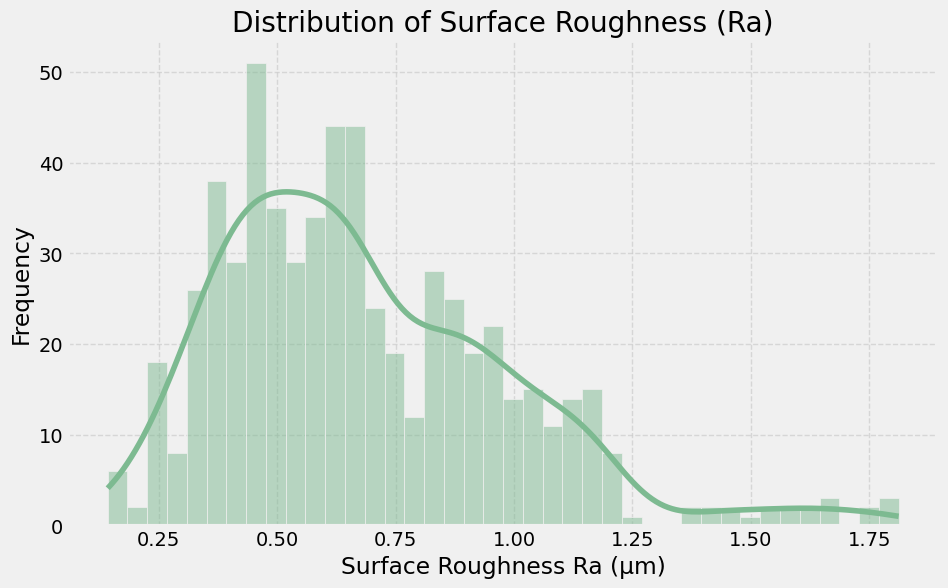

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Surface_Roughness_Ra'], kde=True, bins=40)
plt.title('Distribution of Surface Roughness (Ra)')
plt.xlabel('Surface Roughness Ra (µm)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Key Observations
Most the values fall between ~0.4 and ~0.8 μm. Which means our model may be able to predict well within that range but might struggle anywhere.

there is a right-skewed distribution, this can affect regression models that assume a normal distribution and might lead to biased predictions or overemphasis on outliers unless addressed.
<br><br><br><br>

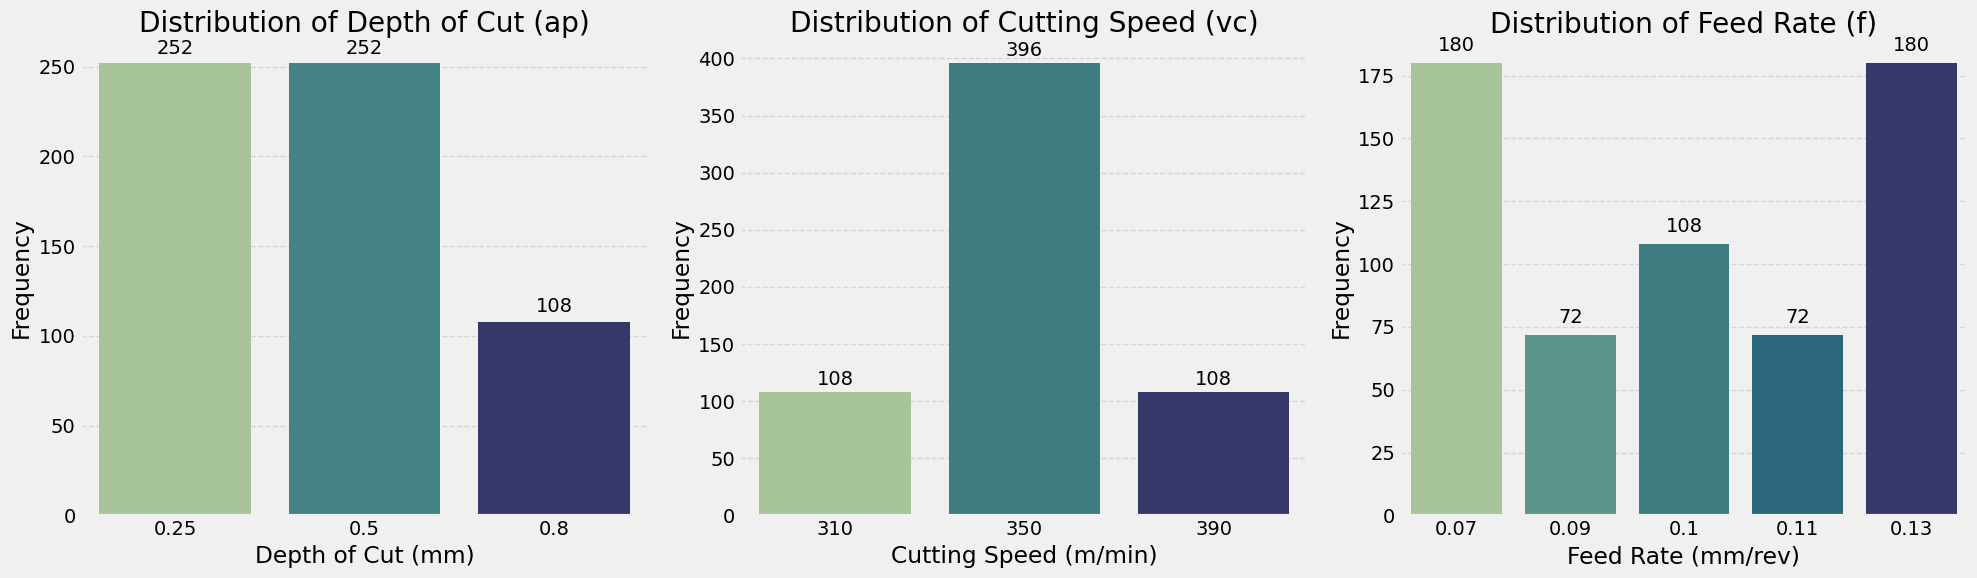

In [10]:
# --- Univariate Analysis: Count Plots for Discrete Parameters with Counts ---

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loop through each parameter to create its count plot and add counts
parameters = ['Depth_of_Cut_ap', 'Cutting_Speed_vc', 'Feed_Rate_f']
x_labels = ['Depth of Cut (mm)', 'Cutting Speed (m/min)', 'Feed Rate (mm/rev)']
titles = ['Distribution of Depth of Cut (ap)', 'Distribution of Cutting Speed (vc)', 'Distribution of Feed Rate (f)']

for i, param in enumerate(parameters):
    ax = axes[i]
    sns.countplot(x=param, data=merged_df, ax=ax, palette='crest',hue=param, legend=False)
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    # Add count labels on top of each bar
    for container in ax.containers: 
        for patch in container.patches:
            height = patch.get_height()
            ax.text(patch.get_x() + patch.get_width() / 2., 
                    height + 3, f'{int(height)}', 
                    ha='center', va='bottom') 

plt.tight_layout()
plt.show()

E:\conda_envs\pytorch_ml\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
E:\conda_envs\pytorch_ml\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


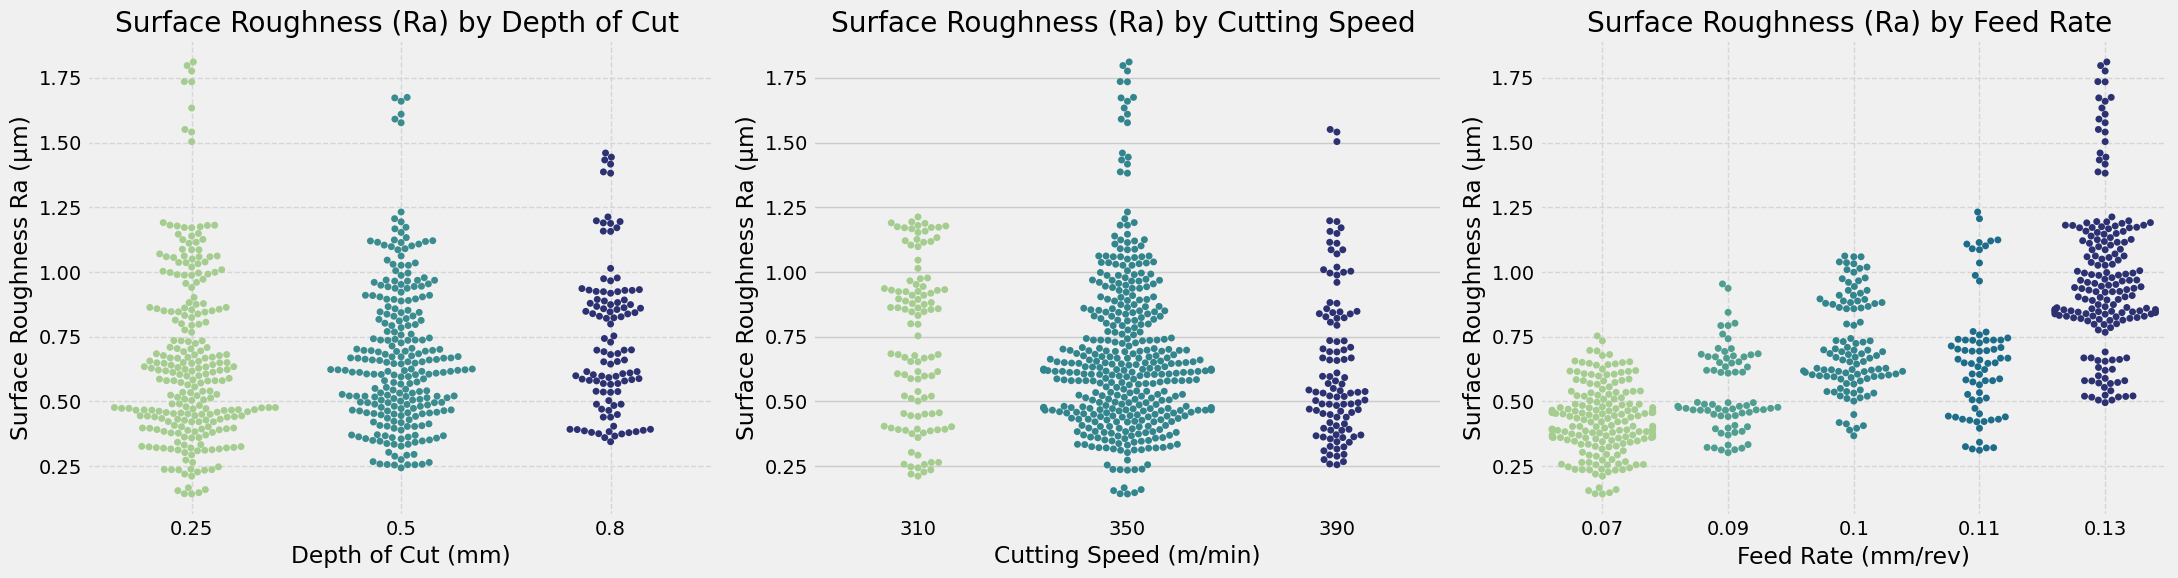

In [11]:
# --- Plots with Swarm Plots ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Ra vs. Depth of Cut with Swarm Plot
sns.swarmplot(x='Depth_of_Cut_ap', y='Surface_Roughness_Ra', data=merged_df, ax=axes[0], hue='Depth_of_Cut_ap', palette='crest', s=5, legend=False)
axes[0].set_title('Surface Roughness (Ra) by Depth of Cut ')
axes[0].set_xlabel('Depth of Cut (mm)')
axes[0].set_ylabel('Surface Roughness Ra (µm)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Cutting Speed with Swarm Plot
sns.swarmplot(x='Cutting_Speed_vc', y='Surface_Roughness_Ra', data=merged_df, ax=axes[1], hue='Cutting_Speed_vc', palette='crest', s=5, legend=False)
axes[1].set_title('Surface Roughness (Ra) by Cutting Speed ')
axes[1].set_xlabel('Cutting Speed (m/min)')
axes[1].set_ylabel('Surface Roughness Ra (µm)')

# Ra vs. Feed Rate with Swarm Plot
sns.swarmplot(x='Feed_Rate_f', y='Surface_Roughness_Ra', data=merged_df, ax=axes[2],hue='Feed_Rate_f', palette='crest', s=5, legend=False)
axes[2].set_title('Surface Roughness (Ra) by Feed Rate ')
axes[2].set_xlabel('Feed Rate (mm/rev)')
axes[2].set_ylabel('Surface Roughness Ra (µm)')
axes[2].grid(True, linestyle='--', alpha=0.7)



plt.tight_layout()
plt.show()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")

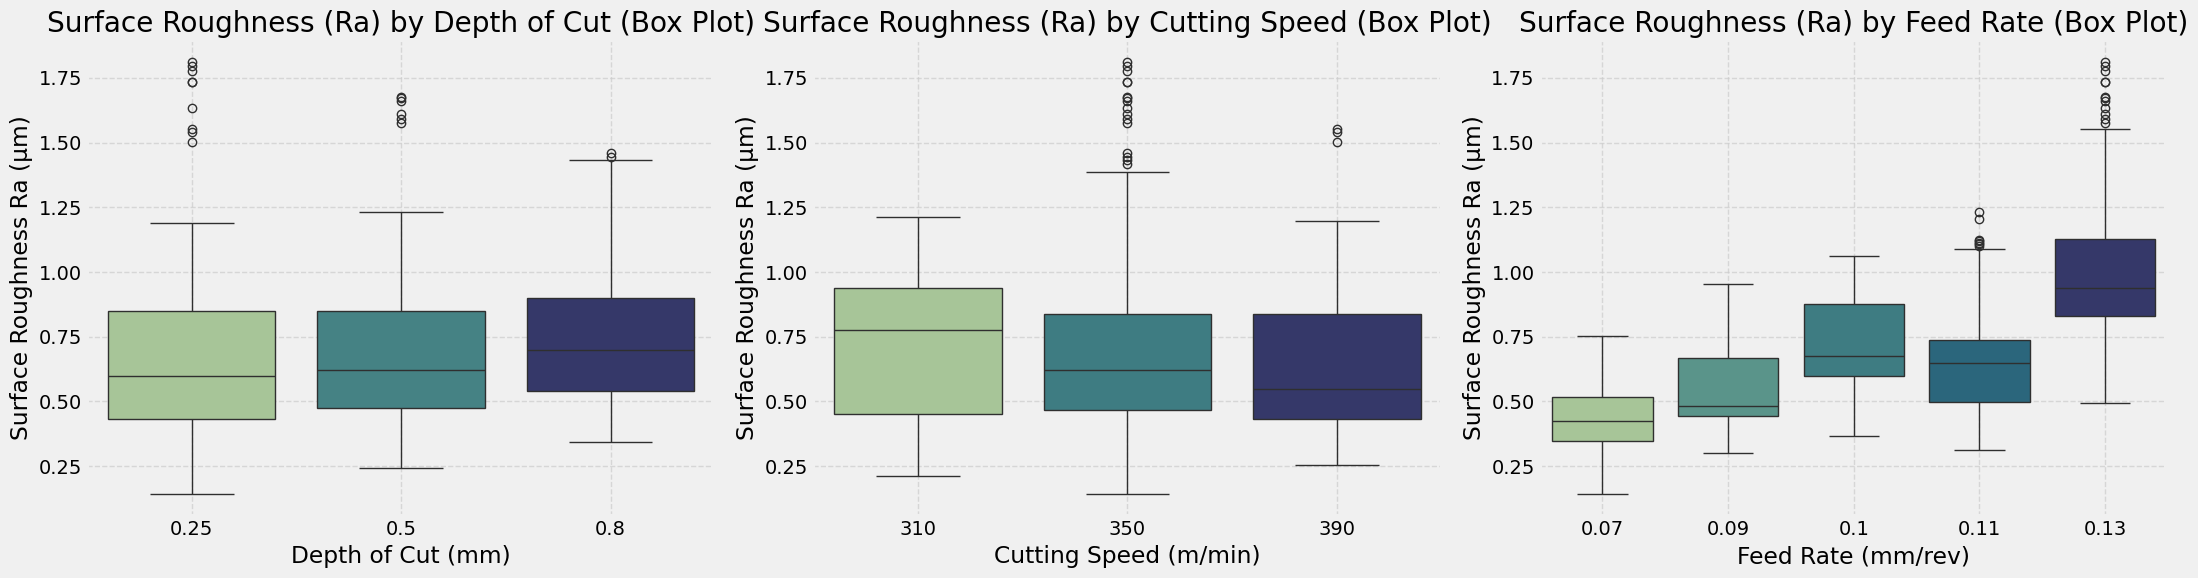

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Ra vs. Depth of Cut with Box Plot
sns.boxplot(x='Depth_of_Cut_ap', y='Surface_Roughness_Ra', data=merged_df, ax=axes[0], hue='Depth_of_Cut_ap', palette='crest', legend=False)
axes[0].set_title('Surface Roughness (Ra) by Depth of Cut (Box Plot)')
axes[0].set_xlabel('Depth of Cut (mm)')
axes[0].set_ylabel('Surface Roughness Ra (µm)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Cutting Speed with Box Plot
sns.boxplot(x='Cutting_Speed_vc', y='Surface_Roughness_Ra', data=merged_df, ax=axes[1], hue='Cutting_Speed_vc', palette='crest', legend=False)
axes[1].set_title('Surface Roughness (Ra) by Cutting Speed (Box Plot)')
axes[1].set_xlabel('Cutting Speed (m/min)')
axes[1].set_ylabel('Surface Roughness Ra (µm)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Feed Rate with Box Plot
sns.boxplot(x='Feed_Rate_f', y='Surface_Roughness_Ra', data=merged_df, ax=axes[2], hue='Feed_Rate_f', palette='crest', legend=False)
axes[2].set_title('Surface Roughness (Ra) by Feed Rate (Box Plot)')
axes[2].set_xlabel('Feed Rate (mm/rev)')
axes[2].set_ylabel('Surface Roughness Ra (µm)')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

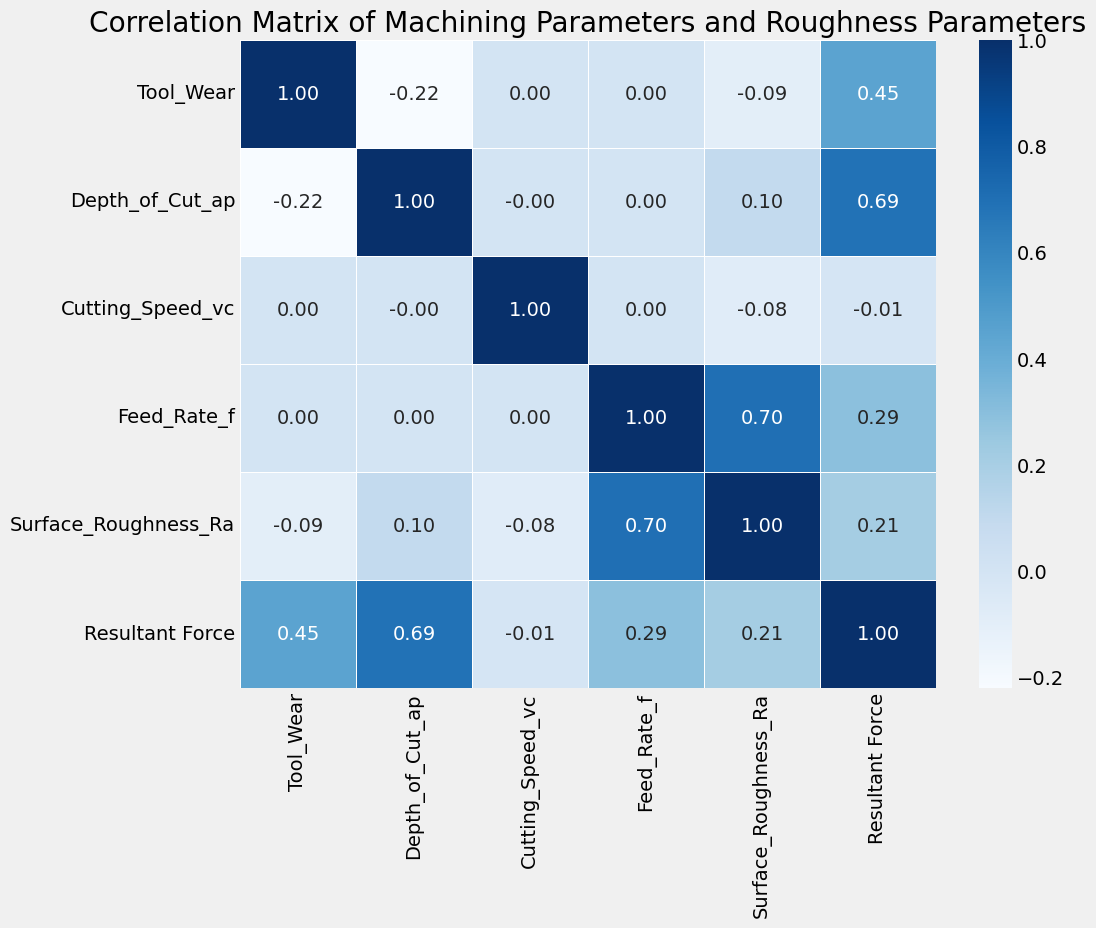

In [13]:
#Correlation Analysis


plt.figure(figsize=(10, 8))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Machining Parameters and Roughness Parameters')
plt.show()

### Correlation Matrix Key Observations:

- Feed Rate (f) is the most influential parameter, showing a direct positive relationship with Surface_Roughness_Ra. This is a critical insight for process control.
- Depth of Cut (ap) and Cutting Speed (vc) appears to have a less direct impact compared to Fx and feed rate
  <br><br><br><br>

### Data Saving 

In [14]:
merged_df.to_csv(f'{base_dir}/data/processed/cleaned_data.csv', index=False)



**EDA Summary :**

`Feed_Rate_f` is the most influential parameter to determine `Surface_Roughness_Ra` with `Cutting_Speed_vc` and `Depth_of_Cut_ap` minimal correlation.


<br><br><br><br><br>



<h2><strong>Modeling / Machine Learning</strong></h2>

`XGBoost(Extreme Gradient Boosting)` and `Random Forest` are both ensemble machine learning algorithms that utilize decision trees as their base learners, but they differ significantly in their approach to building and combining these trees.


<strong>Random Forest:<span style="margin-left: 400px;"></span>XGBoost :</strong>

Builds lots of trees independently. <span style="margin-left: 290px;"></span>Builds trees sequentially, one at a time.

Each tree sees a random subset of data and features.<span style="margin-left: 178px;">Each new tree tries to fix the errors of the previous one.

Final prediction: regression or classification<span style="margin-left: 239px;">Final prediction: weighted combination of all trees.



In [15]:
#base_dir = r"C:\Users\santo\OneDrive\Documents\GitHub\Surface_Roughness"
merged_df = pd.read_csv(f"{base_dir}/data/processed/cleaned_data.csv")

In [16]:
# Define the target variable
target_column = 'Surface_Roughness_Ra'
y = merged_df[target_column]



# Drop the target column to get the feature matrix
X = merged_df.drop(columns=[target_column]).copy()

print(f"Target variable '{target_column}' defined. Shape: {y.shape}")
print(f"Initial features (X) defined. Shape: {X.shape}")
print("\nFirst 5 rows of X:")
print(X.head())

Target variable 'Surface_Roughness_Ra' defined. Shape: (612,)
Initial features (X) defined. Shape: (612, 5)

First 5 rows of X:
   Tool_Wear  Depth_of_Cut_ap  Cutting_Speed_vc  Feed_Rate_f  Resultant Force
0        0.0             0.25               350         0.07        69.600499
1        0.0             0.25               350         0.07        69.600499
2        0.0             0.25               350         0.07        69.600499
3        0.0             0.25               350         0.07        69.600499
4        0.0             0.25               350         0.07        69.600499


### Data Scaling

Scaling numerical features is a critical preprocessing step for many machine learning algorithms. While tree-based models (like Random Forest and XGBoost, which we plan to use) are less sensitive to feature scales, scaling is good practice for:


In [17]:
print("\nScaling numerical features using StandardScaler...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to X and transform X
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame, preserving column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


print(X_scaled_df.head())


Scaling numerical features using StandardScaler...
   Tool_Wear  Depth_of_Cut_ap  Cutting_Speed_vc  Feed_Rate_f  Resultant Force
0   -0.57886        -1.011215               0.0    -1.275798        -1.338158
1   -0.57886        -1.011215               0.0    -1.275798        -1.338158
2   -0.57886        -1.011215               0.0    -1.275798        -1.338158
3   -0.57886        -1.011215               0.0    -1.275798        -1.338158
4   -0.57886        -1.011215               0.0    -1.275798        -1.338158


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Evaluation for Multiple Models

In [19]:
import pandas as pd

# Store results here
results = []

# Define the models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the list
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R^2': r2
    })

# Convert list of dicts to DataFrame
results_df = pd.DataFrame(results)





--- Training and Evaluating RandomForestRegressor ---

--- Training and Evaluating XGBoostRegressor ---

--- Training and Evaluating KNeighborsRegressor ---


In [20]:
results_df = results_df.reset_index(drop=True)
results_df

,Model,MAE,MSE,RMSE,MAPE,R^2
0,RandomForestRegressor,0.032403,0.003203,0.056598,0.046747,0.968229
1,XGBoostRegressor,0.032181,0.003127,0.055917,0.046265,0.968989
2,KNeighborsRegressor,0.070930,0.010207,0.101027,0.103738,0.898771


* **MAE (Mean Absolute Error):** Average size of errors.


* **MSE (Mean Squared Error):** Penalizes larger errors more.
* **RMSE (Root Mean Squared Error):** Typical error size, same units as target.
* **MAPE (Mean Absolute Percentage Error):** Average error as a percentage.
* **R² (Coefficient of Determination):** How much variance is explained.

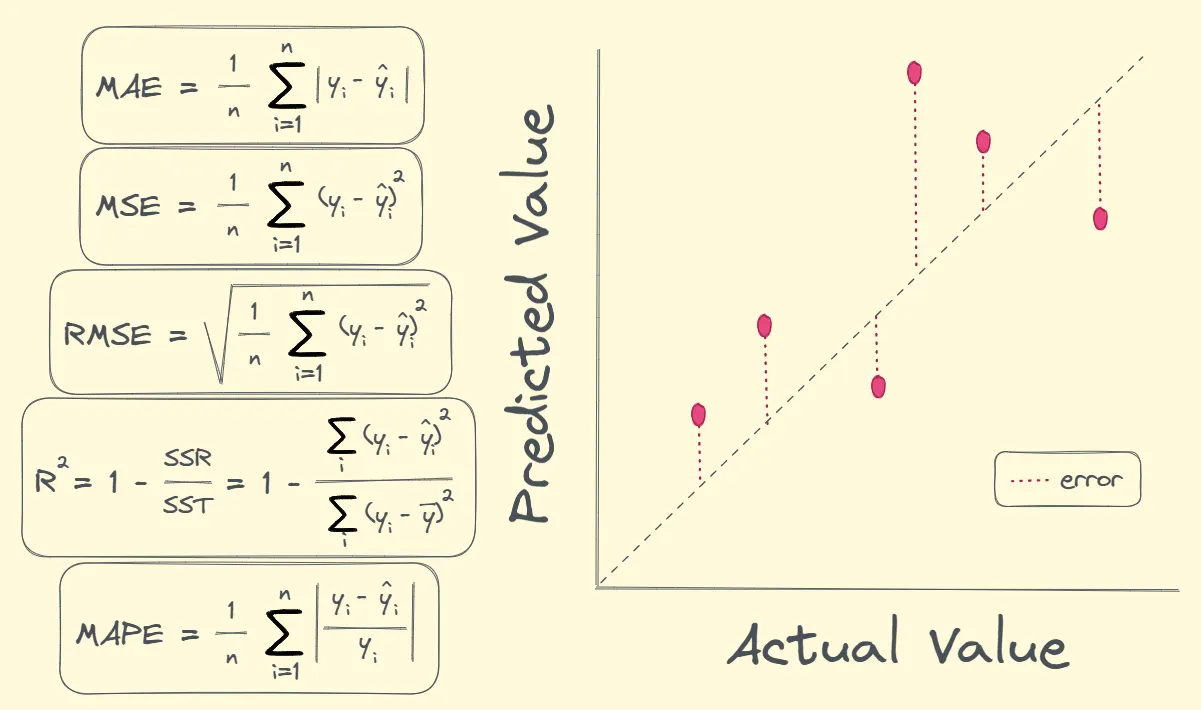

In [21]:
from IPython.display import Image, display
display(Image(filename=f"{base_dir}/images/eval.webp", width=800))

In [22]:



# Define the models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KKNeighborsRegressor' : KNeighborsRegressor(n_neighbors=5),

}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")



    print(f"Training {name} model...")
    model.fit(X_train, y_train)
    print(f"{name} training complete.")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"    Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")



--- Training and Evaluating RandomForestRegressor ---
Training RandomForestRegressor model...
RandomForestRegressor training complete.
  Mean Absolute Error (MAE): 0.0324
  Mean Squared Error (MSE): 0.0032
  Root Mean Squared Error (RMSE): 0.0566
    Mean Absolute Percentage Error (MAPE): 0.0467
  R-squared (R2): 0.9682

--- Training and Evaluating XGBoostRegressor ---
Training XGBoostRegressor model...
XGBoostRegressor training complete.
  Mean Absolute Error (MAE): 0.0322
  Mean Squared Error (MSE): 0.0031
  Root Mean Squared Error (RMSE): 0.0559
    Mean Absolute Percentage Error (MAPE): 0.0463
  R-squared (R2): 0.9690

--- Training and Evaluating KKNeighborsRegressor ---
Training KKNeighborsRegressor model...
KKNeighborsRegressor training complete.
  Mean Absolute Error (MAE): 0.0709
  Mean Squared Error (MSE): 0.0102
  Root Mean Squared Error (RMSE): 0.1010
    Mean Absolute Percentage Error (MAPE): 0.1037
  R-squared (R2): 0.8988



--- Training and Evaluating RandomForestRegressor with Grid Search ---
Performing Grid Search for RandomForestRegressor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestRegressor Grid Search complete. Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}

Training RandomForestRegressor model with best parameters...
RandomForestRegressor training complete.

  Mean Absolute Error (MAE): 0.0320
  Mean Squared Error (MSE): 0.0031
  Root Mean Squared Error (RMSE): 0.0557
  Mean Absolute Percentage Error (MAPE): 4.6105%
  R-squared (R2): 0.9693


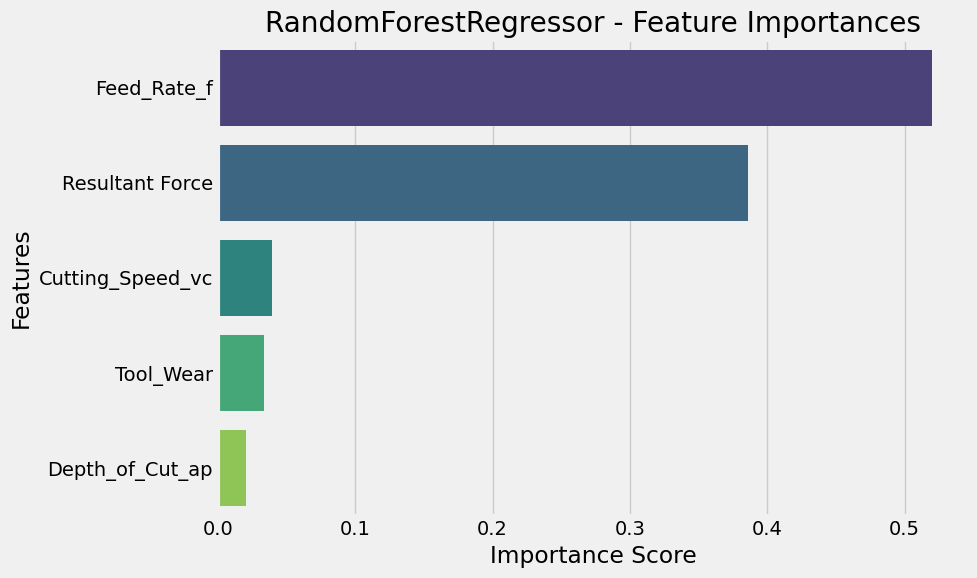


--- Training and Evaluating XGBoostRegressor with Grid Search ---
Performing Grid Search for XGBoostRegressor...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
XGBoostRegressor Grid Search complete. Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'subsample': 1.0}

Training XGBoostRegressor model with best parameters...
XGBoostRegressor training complete.

  Mean Absolute Error (MAE): 0.0320
  Mean Squared Error (MSE): 0.0031
  Root Mean Squared Error (RMSE): 0.0559
  Mean Absolute Percentage Error (MAPE): 4.6052%
  R-squared (R2): 0.9691


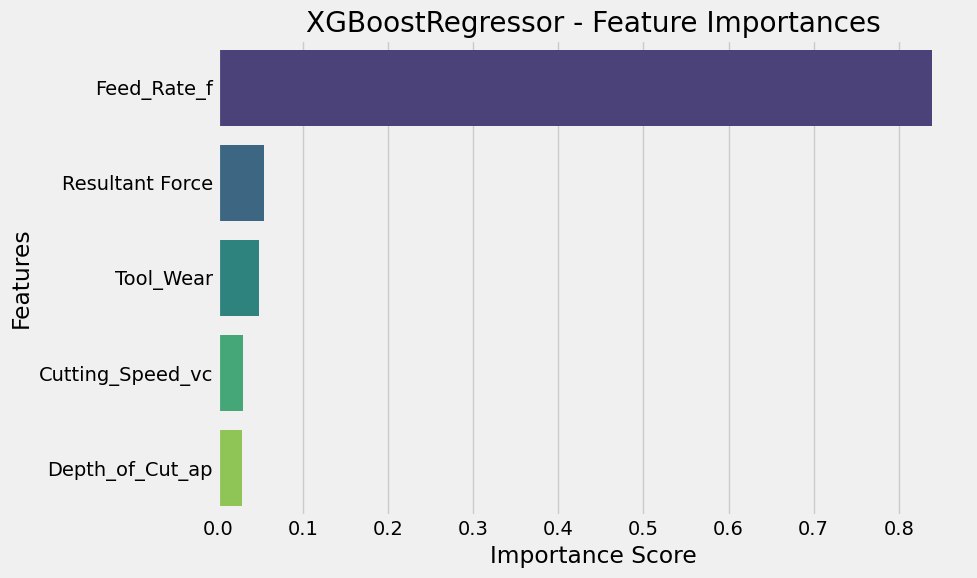


--- Training and Evaluating KNeighborsRegressor with Grid Search ---
Performing Grid Search for KNeighborsRegressor...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
KNeighborsRegressor Grid Search complete. Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

Training KNeighborsRegressor model with best parameters...
KNeighborsRegressor training complete.

  Mean Absolute Error (MAE): 0.0320
  Mean Squared Error (MSE): 0.0031
  Root Mean Squared Error (RMSE): 0.0558
  Mean Absolute Percentage Error (MAPE): 4.5867%
  R-squared (R2): 0.9691


In [23]:
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_split': [2, 5],
        }
    },
    'XGBoostRegressor': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7, 10, 15],
            'subsample': [0.6,0.7, 1.0],
            'colsample_bytree': [0.6, 0.7, 1.0]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': list(range(1, 21)),
            'weights': ['uniform', 'distance'],
            'p': [1, 2, 3], 
        }
    },
}

# Directory to save the models
model_save_dir = f"{base_dir}/trained_models/"

os.makedirs(model_save_dir, exist_ok=True)

for name, model_info in models.items():
    print(f"\n--- Training and Evaluating {name} with Grid Search ---")

    model = model_info['model']
    param_grid = model_info['param_grid']

    print(f"Performing Grid Search for {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"{name} Grid Search complete. Best parameters: {grid_search.best_params_}\n")
    print(f"Training {name} model with best parameters...")
    print(f"{name} training complete.\n")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    # Coefficient of Determination
    r2 = r2_score(y_test, y_pred)

    
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.4f}%")  
    print(f"  R-squared (R2): {r2:.4f}")
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(importances))]
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[sorted_idx], y=[feature_names[i] for i in sorted_idx], palette='viridis', hue=[feature_names[i] for i in sorted_idx])
        plt.title(f"{name} - Feature Importances")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()


In [24]:
for name, model_info in models.items():

    best_model = grid_search.best_estimator_

    # Save the best model
    model_filename = os.path.join(model_save_dir, f"{name.lower()}_best_model.pkl")
    joblib.dump(best_model, model_filename)
    print(f"Best {name} model saved to directory")

print("\nAll models trained saved.")

Best RandomForestRegressor model saved to directory
Best XGBoostRegressor model saved to directory
Best KNeighborsRegressor model saved to directory

All models trained saved.


<strong>Purpose:</strong>
     
    - Visualize how close your predictions are to the actual values.

    - Ideally, all points should fall close to the diagonal line y = x.

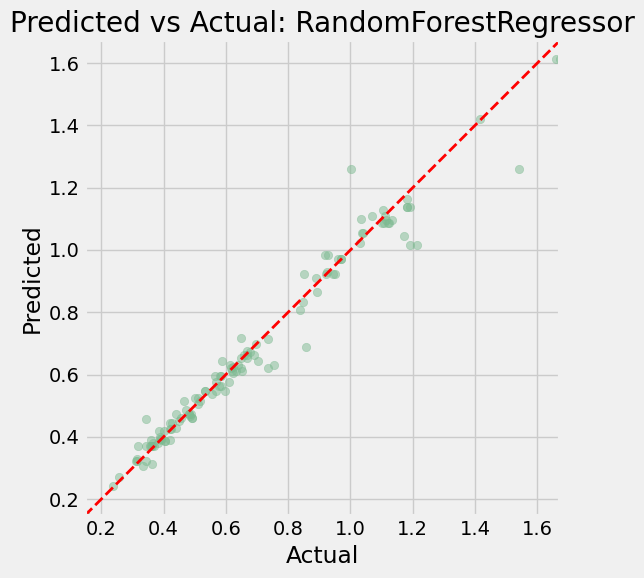

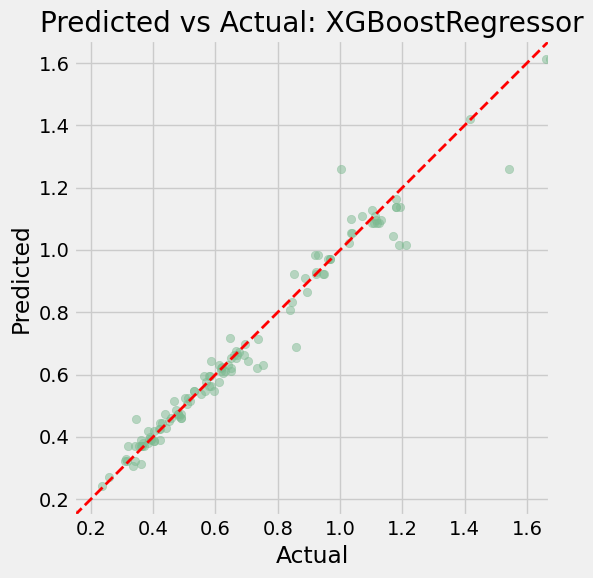

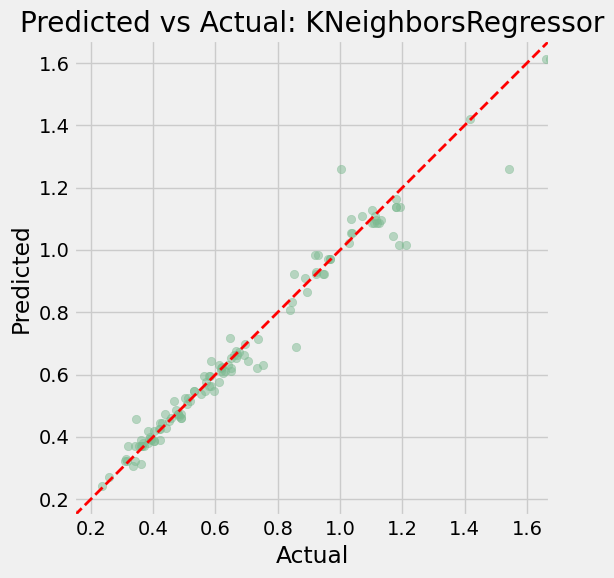

In [25]:

    for name, model in models.items():
        lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot(lims, lims, 'r--', lw=2)
        plt.xlim(lims); plt.ylim(lims)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Predicted vs Actual: {name}")
        plt.tight_layout()
        plt.show()


In [26]:
Image(filename=f"{base_dir}/images/residuals.png', width=500)

SyntaxError: unterminated string literal (detected at line 1) (2117394210.py, line 1)

In [ ]:
for name, model in models.items():
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.title(f"Residual Plot: {name}")
    plt.tight_layout()
    plt.show()



## Dropping Force Reading from Dataset

In [ ]:
X_train = X_train.drop(columns=['F'])
X_test = X_test.drop(columns=['F'])

# Define the models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KKNeighborsRegressor' : KNeighborsRegressor(n_neighbors=5),

}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")



    print(f"Training {name} model...")
    model.fit(X_train, y_train)
    print(f"{name} training complete.")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"    Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")

